# Collaboration and Competition

---

Congratulations for completing the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control agents in a more challenging environment, where the goal is to train a team of agents to play soccer.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import pprint 
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from ppo_agent import PPO_Agent
from params import Params
from logger import Logger
from logger_team import Logger_Team
from CustomSummaryWriter import CustomSummaryWriter

In [3]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [4]:
## For Debugging (Might slow progress quite alot!)
#torch.autograd.set_detect_anomaly(True)
#np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Soccer.app"`
- **Windows** (x86): `"path/to/Soccer_Windows_x86/Soccer.exe"`
- **Windows** (x86_64): `"path/to/Soccer_Windows_x86_64/Soccer.exe"`
- **Linux** (x86): `"path/to/Soccer_Linux/Soccer.x86"`
- **Linux** (x86_64): `"path/to/Soccer_Linux/Soccer.x86_64"`
- **Linux** (x86, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86"`
- **Linux** (x86_64, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86_64"`

For instance, if you are using a Mac, then you downloaded `Soccer.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Soccer.app")
```

In [4]:
env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe')
#env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [5]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
# for i in range(2):                                         # play game for 2 episodes
#     env_info = env.reset(train_mode=False)                 # reset the environment    
#     g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
#     s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
#     g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
#     s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
#     while True:
#         # select actions and send to environment
#         g_actions = np.random.randint(g_action_size, size=num_g_agents)
#         s_actions = np.random.randint(s_action_size, size=num_s_agents)
#         actions = dict(zip([g_brain_name, s_brain_name], 
#                            [g_actions, s_actions]))
#         env_info = env.step(actions)                       
        
#         # get next states
#         g_next_states = env_info[g_brain_name].vector_observations         
#         s_next_states = env_info[s_brain_name].vector_observations
        
#         # get reward and update scores
#         g_rewards = env_info[g_brain_name].rewards  
#         s_rewards = env_info[s_brain_name].rewards
#         g_scores += g_rewards
#         s_scores += s_rewards
        
#         # check if episode finished
#         done = np.any(env_info[g_brain_name].local_done)  
        
#         # roll over states to next time step
#         g_states = g_next_states
#         s_states = s_next_states
        
#         # exit loop if episode finished
#         if done:                                           
#             break
#     print('Scores from episode {}: {} (goalies), {} (strikers)'.format(i+1, g_scores, s_scores))

Scores from episode 1: [1.00166669 1.00166669] (goalies), [-1.00166669 -1.00166669] (strikers)
Scores from episode 2: [ 0.46833333 -0.63166678] (goalies), [ 0.63166678 -0.46833333] (strikers)


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

# Training against a Random Agent

In [30]:
def ppo(params=Params(), g_logger=Logger(), s_logger=Logger(), team_logger=Logger_Team()):
    
    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now()         
    env_info = env.reset(train_mode=True)
    g_logger.initialize(g_agent, g_state_size, g_action_size)
    s_logger.initialize(s_agent, s_state_size, s_action_size)
    step = 0

    try:
        start_eps = params.eps_to_resume_from if not params.restart_training else 1        
        for i_episode in range(start_eps, params.n_episodes+1):
            env_info = env.reset(train_mode=True)                  # reset the environment
            g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
            s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)            
            g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
            s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
            num_steps = 0

            for t in range(params.max_t):    
                num_steps = t

                # Perform actions from each agent's policy network (clipped actions [0, -1])
                g_action, g_log_prob = g_agent.act(g_states[0])
                s_action, s_log_prob = s_agent.act(s_states[0])
                g_actions = (g_action, np.random.randint(g_action_size))
                s_actions = (s_action, np.random.randint(s_action_size))
                actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
                env_info = env.step(actions)                   

                # get next states, rewards & dones
                g_next_states = env_info[g_brain_name].vector_observations         
                s_next_states = env_info[s_brain_name].vector_observations
                g_rewards = env_info[g_brain_name].rewards  
                s_rewards = env_info[s_brain_name].rewards
                done = np.any(env_info[g_brain_name].local_done) 

                # Store in experience buffer & learn
                all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
                g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
                s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
                g_states = g_next_states
                s_states = s_next_states
                g_scores += g_rewards
                s_scores += s_rewards                

                # Break if game is over (time out / score)
                if done:   
                    break 

            # Learn from episode
            g_agent.learn()
            s_agent.learn()

            # Print crucial results for progress tracking
            for i in range(len(g_agent.actor_losses)):
                step += 1
                g_logger.log_stats(step, g_scores[0], g_agent.actor_losses[i], g_agent.critic_losses[i], g_agent.entropy_losses[i])
                s_logger.log_stats(step, s_scores[0], s_agent.actor_losses[i], s_agent.critic_losses[i], s_agent.entropy_losses[i])
            g_logger.log_weights(i_episode)
            s_logger.log_weights(i_episode)
            team_logger.log_stats(i_episode, g_scores[0] + s_scores[0], g_scores[1] + s_scores[1])
            print('\rEpisode {}: \tNum Steps: {} \t G_score: {:.2f} \t S_Score: {:.2f}  \tWin: {} \t\t'.format(i_episode, num_steps, g_logger.scores_deque[-1], 
                                                            s_logger.scores_deque[-1], team_logger.wins_deque[-1]), end="")

            if i_episode % params.save_every == 0:
                s_logger.save_weights(i_episode)
                g_logger.save_weights(i_episode)

            if i_episode % params.print_every == 0:
                print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
                      .format(i_episode, team_logger.scores_cum_deque[-1], team_logger.scores_opp_cum_deque[-1], np.count_nonzero(team_logger.wins_deque), 
                              np.count_nonzero(team_logger.lose_deque), np.count_nonzero(team_logger.draws_deque), len(team_logger.wins_deque)))

                if team_logger.scores_cum_deque[-1] >= params.target_score:
                    print('\nEnvironment solved in {:d} episodes!\tAvg Total Score: {:.2f} \tAvg Total Wins: {}/{}'
                          .format(i_episode, np.mean(team_logger.scores_deque), np.count_nonzero(team_logger.wins_deque), len(team_logger.wins_deque)))
                    if params.terminate_on_target_score:
                        break

        # Plot graphs & save final weights
        g_logger.save_weights(i_episode)
        s_logger.save_weights(i_episode)
        if params.plot_stats:
            team_logger.plot_stats()
            g_logger.plot_stats()                       
            s_logger.plot_stats()
        team_logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    # Catch any exceptions (Esp with keyboard interrupts)
    except BaseException as error:
        print('\n\n==== An exception occurred: {}'.format(error))
        g_logger.save_weights(i_episode)
        s_logger.save_weights(i_episode)
        if params.plot_stats:
            team_logger.plot_stats()
            g_logger.plot_stats()                       
            s_logger.plot_stats()
        team_logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return s_logger.scores_list


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  0.0001
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  0.0001
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0




============ Goalie HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3)

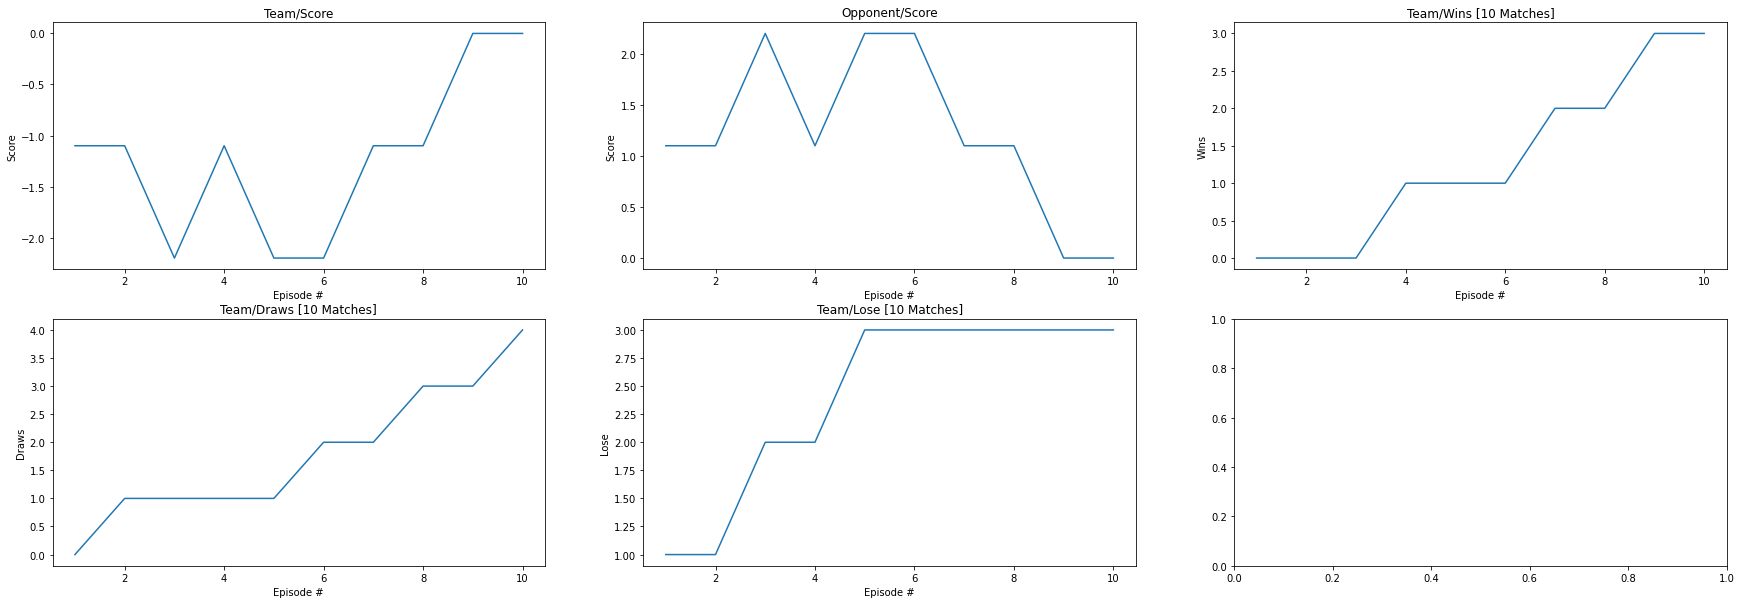

===== Goalie =====


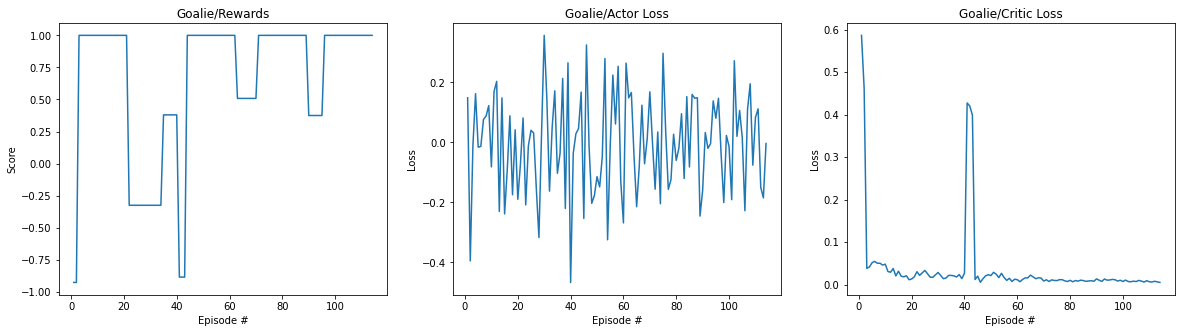

===== Striker =====


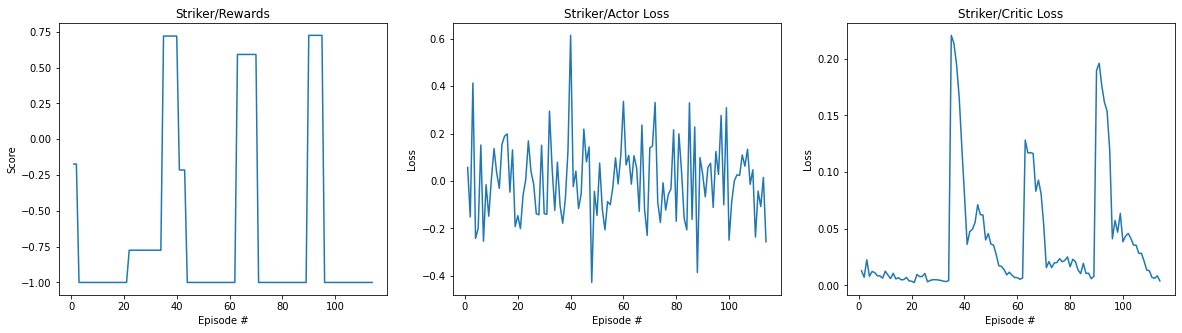

TOTAL TRAINING DURATION: 0 days, 0 hours, 0 minutes and 37 seconds
***TRAINING STOPPED AT 2022-04-02--12:03:00 


[-0.17333333496935666,
 -0.17333333496935666,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 -0.7750000162050128,
 0.7199999948497862,
 0.7199999948497862,
 0.7199999948497862,
 0.7199999948497862,
 0.7199999948497862,
 0.7199999948497862,
 -0.21499999519437551,
 -0.21499999519437551,
 -0.21499999519437551,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.0000000

In [29]:
##################
# QUICK TEST
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=10
params.max_t = 600
params.print_every = 2
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32

# Goalie Params
g_params = copy.deepcopy(params)
g_params.lr = 1e-4  
g_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/goalie_expt'
g_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/goalie_expt'

# Striker Params
s_params = copy.deepcopy(params)
s_params.lr = 8e-5  
s_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/striker_expt'
s_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/striker_expt'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(g_params, tb, "Goalie")
s_logger = Logger(s_params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


============ Goalie HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


============ Striker HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR (Joint):  0.0001
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.9975
BETA_MIN:  5e-05
EPS:  0.1
EPS_DECAY:  1
EPS_MIN:  0.1
WEIGHT_DECAY:  0


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc

Episode 1360: 	Team Score: 14.30 	Opponent Score: -14.30 	 Win|Lose|Draw: 43|30|27 	 [Out of 100 Matches]
Episode 1380: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 40|37|23 	 [Out of 100 Matches]
Episode 1400: 	Team Score: -2.20 	Opponent Score: 2.20 	 Win|Lose|Draw: 36|38|26 	 [Out of 100 Matches]
Episode 1420: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 40|37|23 	 [Out of 100 Matches]
Episode 1440: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 40|34|26 	 [Out of 100 Matches]
Episode 1460: 	Team Score: 14.30 	Opponent Score: -14.30 	 Win|Lose|Draw: 45|32|23 	 [Out of 100 Matches]
Episode 1480: 	Team Score: 28.60 	Opponent Score: -28.60 	 Win|Lose|Draw: 53|27|20 	 [Out of 100 Matches]
Episode 1500: 	Team Score: 31.90 	Opponent Score: -31.90 	 Win|Lose|Draw: 56|27|17 	 [Out of 100 Matches]
Episode 1520: 	Team Score: 24.20 	Opponent Score: -24.20 	 Win|Lose|Draw: 52|30|18 	 [Out of 100 Matches]
Episode 1540: 	Team Score: 18.70 	Opponent Score: -18.

Episode 2900: 	Team Score: 38.50 	Opponent Score: -38.50 	 Win|Lose|Draw: 59|24|17 	 [Out of 100 Matches]
Episode 2920: 	Team Score: 35.20 	Opponent Score: -35.20 	 Win|Lose|Draw: 57|25|18 	 [Out of 100 Matches]
Episode 2940: 	Team Score: 33.00 	Opponent Score: -33.00 	 Win|Lose|Draw: 54|24|22 	 [Out of 100 Matches]
Episode 2960: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 55|22|23 	 [Out of 100 Matches]
Episode 2980: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 56|23|21 	 [Out of 100 Matches]
Episode 3000: 	Team Score: 36.30 	Opponent Score: -36.30 	 Win|Lose|Draw: 55|22|23 	 [Out of 100 Matches]
Episode 3020: 	Team Score: 42.90 	Opponent Score: -42.90 	 Win|Lose|Draw: 56|17|27 	 [Out of 100 Matches]
Episode 3040: 	Team Score: 42.90 	Opponent Score: -42.90 	 Win|Lose|Draw: 58|19|23 	 [Out of 100 Matches]
Episode 3060: 	Team Score: 44.00 	Opponent Score: -44.00 	 Win|Lose|Draw: 57|17|26 	 [Out of 100 Matches]
Episode 3080: 	Team Score: 39.60 	Opponent Sco

Episode 4440: 	Team Score: 63.80 	Opponent Score: -63.80 	 Win|Lose|Draw: 72|14|14 	 [Out of 100 Matches]
Episode 4460: 	Team Score: 69.30 	Opponent Score: -69.30 	 Win|Lose|Draw: 75|12|13 	 [Out of 100 Matches]
Episode 4480: 	Team Score: 61.60 	Opponent Score: -61.60 	 Win|Lose|Draw: 70|14|16 	 [Out of 100 Matches]
Episode 4500: 	Team Score: 57.20 	Opponent Score: -57.20 	 Win|Lose|Draw: 67|15|18 	 [Out of 100 Matches]
Episode 4520: 	Team Score: 52.80 	Opponent Score: -52.80 	 Win|Lose|Draw: 66|18|16 	 [Out of 100 Matches]
Episode 4540: 	Team Score: 56.10 	Opponent Score: -56.10 	 Win|Lose|Draw: 66|15|19 	 [Out of 100 Matches]
Episode 4560: 	Team Score: 48.40 	Opponent Score: -48.40 	 Win|Lose|Draw: 62|18|20 	 [Out of 100 Matches]
Episode 4580: 	Team Score: 45.10 	Opponent Score: -45.10 	 Win|Lose|Draw: 60|19|21 	 [Out of 100 Matches]
Episode 4600: 	Team Score: 48.40 	Opponent Score: -48.40 	 Win|Lose|Draw: 63|19|18 	 [Out of 100 Matches]
Episode 4620: 	Team Score: 48.40 	Opponent Sco

Episode 5980: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 74|13|13 	 [Out of 100 Matches]
Episode 6000: 	Team Score: 73.70 	Opponent Score: -73.70 	 Win|Lose|Draw: 78|11|11 	 [Out of 100 Matches]
Episode 6020: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 72|11|17 	 [Out of 100 Matches]
Episode 6040: 	Team Score: 67.10 	Opponent Score: -67.10 	 Win|Lose|Draw: 72|11|17 	 [Out of 100 Matches]
Episode 6060: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 77|7|16 	 [Out of 100 Matches]
Episode 6080: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 83|5|12 	 [Out of 100 Matches]
Episode 6100: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 81|6|13 	 [Out of 100 Matches]
Episode 6120: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 84|7|9 	 [Out of 100 Matches]
Episode 6140: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 85|7|8 	 [Out of 100 Matches]
Episode 6160: 	Team Score: 82.50 	Opponent Score: -82

Episode 7540: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 83|13|4 	 [Out of 100 Matches]
Episode 7560: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 83|15|2 	 [Out of 100 Matches]
Episode 7580: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 80|18|2 	 [Out of 100 Matches]
Episode 7600: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 79|17|4 	 [Out of 100 Matches]
Episode 7620: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 81|15|4 	 [Out of 100 Matches]
Episode 7640: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 83|13|4 	 [Out of 100 Matches]
Episode 7660: 	Team Score: 80.30 	Opponent Score: -80.30 	 Win|Lose|Draw: 84|11|5 	 [Out of 100 Matches]
Episode 7680: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 84|10|6 	 [Out of 100 Matches]
Episode 7700: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 87|9|4 	 [Out of 100 Matches]
Episode 7720: 	Team Score: 86.90 	Opponent Score: -86.90

Episode 9100: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 84|9|7 	 [Out of 100 Matches]
Episode 9120: 	Team Score: 78.10 	Opponent Score: -78.10 	 Win|Lose|Draw: 82|11|7 	 [Out of 100 Matches]
Episode 9140: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 81|12|7 	 [Out of 100 Matches]
Episode 9160: 	Team Score: 73.70 	Opponent Score: -73.70 	 Win|Lose|Draw: 80|13|7 	 [Out of 100 Matches]
Episode 9180: 	Team Score: 70.40 	Opponent Score: -70.40 	 Win|Lose|Draw: 79|15|6 	 [Out of 100 Matches]
Episode 9200: 	Team Score: 71.50 	Opponent Score: -71.50 	 Win|Lose|Draw: 80|15|5 	 [Out of 100 Matches]
Episode 9220: 	Team Score: 70.40 	Opponent Score: -70.40 	 Win|Lose|Draw: 79|15|6 	 [Out of 100 Matches]
Episode 9240: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 78|10|12 	 [Out of 100 Matches]
Episode 9260: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 83|7|10 	 [Out of 100 Matches]
Episode 9280: 	Team Score: 92.40 	Opponent Score: -92.4

Episode 10660: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 84|7|9 	 [Out of 100 Matches]
Episode 10680: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 83|9|8 	 [Out of 100 Matches]
Episode 10700: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 84|8|8 	 [Out of 100 Matches]
Episode 10720: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 78|8|14 	 [Out of 100 Matches]
Episode 10740: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 77|9|14 	 [Out of 100 Matches]
Episode 10760: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 84|6|10 	 [Out of 100 Matches]
Episode 10780: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 84|7|9 	 [Out of 100 Matches]
Episode 10800: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 83|8|9 	 [Out of 100 Matches]
Episode 10820: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 85|9|6 	 [Out of 100 Matches]
Episode 10840: 	Team Score: 79.20 	Opponent Score: -

Episode 12200: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 90|6|4 	 [Out of 100 Matches]
Episode 12220: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 90|6|4 	 [Out of 100 Matches]
Episode 12240: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 12260: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 94|3|3 	 [Out of 100 Matches]
Episode 12280: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 12300: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 91|5|4 	 [Out of 100 Matches]
Episode 12320: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 89|6|5 	 [Out of 100 Matches]
Episode 12340: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 88|7|5 	 [Out of 100 Matches]
Episode 12360: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 87|7|6 	 [Out of 100 Matches]
Episode 12380: 	Team Score: 86.90 	Opponent Score: -8

Episode 13740: 	Team Score: 82.50 	Opponent Score: -82.50 	 Win|Lose|Draw: 81|6|13 	 [Out of 100 Matches]
Episode 13760: 	Team Score: 79.20 	Opponent Score: -79.20 	 Win|Lose|Draw: 80|8|12 	 [Out of 100 Matches]
Episode 13780: 	Team Score: 79.20 	Opponent Score: -79.20 	 Win|Lose|Draw: 80|8|12 	 [Out of 100 Matches]
Episode 13800: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 80|6|14 	 [Out of 100 Matches]
Episode 13820: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 82|5|13 	 [Out of 100 Matches]
Episode 13840: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 86|4|10 	 [Out of 100 Matches]
Episode 13860: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 89|1|10 	 [Out of 100 Matches]
Episode 13880: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 90|2|8 	 [Out of 100 Matches]
Episode 13900: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 91|2|7 	 [Out of 100 Matches]
Episode 13920: 	Team Score: 94.60 	Opponent Scor

Episode 15280: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|2|15 	 [Out of 100 Matches]
Episode 15300: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 83|3|14 	 [Out of 100 Matches]
Episode 15320: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 82|4|14 	 [Out of 100 Matches]
Episode 15340: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|2|15 	 [Out of 100 Matches]
Episode 15360: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 84|2|14 	 [Out of 100 Matches]
Episode 15380: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|10 	 [Out of 100 Matches]
Episode 15400: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 90|3|7 	 [Out of 100 Matches]
Episode 15420: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 91|2|7 	 [Out of 100 Matches]
Episode 15440: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 92|3|5 	 [Out of 100 Matches]
Episode 15460: 	Team Score: 94.60 	Opponent Score

Episode 16820: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 91|2|7 	 [Out of 100 Matches]
Episode 16840: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 93|1|6 	 [Out of 100 Matches]
Episode 16860: 	Team Score: 104.50 	Opponent Score: -104.50 	 Win|Lose|Draw: 95|0|5 	 [Out of 100 Matches]
Episode 16880: 	Team Score: 104.50 	Opponent Score: -104.50 	 Win|Lose|Draw: 95|0|5 	 [Out of 100 Matches]
Episode 16900: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 93|1|6 	 [Out of 100 Matches]
Episode 16920: 	Team Score: 99.00 	Opponent Score: -99.00 	 Win|Lose|Draw: 92|2|6 	 [Out of 100 Matches]
Episode 16940: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 93|2|5 	 [Out of 100 Matches]
Episode 16960: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 93|2|5 	 [Out of 100 Matches]
Episode 16980: 	Team Score: 99.00 	Opponent Score: -99.00 	 Win|Lose|Draw: 92|2|6 	 [Out of 100 Matches]
Episode 17000: 	Team Score: 101.20 	Opponen

Episode 18360: 	Team Score: 77.00 	Opponent Score: -77.00 	 Win|Lose|Draw: 76|6|18 	 [Out of 100 Matches]
Episode 18380: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 76|7|17 	 [Out of 100 Matches]
Episode 18400: 	Team Score: 74.80 	Opponent Score: -74.80 	 Win|Lose|Draw: 75|7|18 	 [Out of 100 Matches]
Episode 18420: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 73|7|20 	 [Out of 100 Matches]
Episode 18440: 	Team Score: 75.90 	Opponent Score: -75.90 	 Win|Lose|Draw: 76|7|17 	 [Out of 100 Matches]
Episode 18460: 	Team Score: 79.20 	Opponent Score: -79.20 	 Win|Lose|Draw: 77|5|18 	 [Out of 100 Matches]
Episode 18480: 	Team Score: 80.30 	Opponent Score: -80.30 	 Win|Lose|Draw: 78|5|17 	 [Out of 100 Matches]
Episode 18500: 	Team Score: 72.60 	Opponent Score: -72.60 	 Win|Lose|Draw: 74|8|18 	 [Out of 100 Matches]
Episode 18520: 	Team Score: 68.20 	Opponent Score: -68.20 	 Win|Lose|Draw: 72|10|18 	 [Out of 100 Matches]
Episode 18540: 	Team Score: 67.10 	Opponent S

Episode 19900: 	Team Score: 99.00 	Opponent Score: -99.00 	 Win|Lose|Draw: 91|1|8 	 [Out of 100 Matches]
Episode 19920: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 94|0|6 	 [Out of 100 Matches]
Episode 19940: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 90|3|7 	 [Out of 100 Matches]
Episode 19960: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 89|3|8 	 [Out of 100 Matches]
Episode 19980: 	Team Score: 97.90 	Opponent Score: -97.90 	 Win|Lose|Draw: 92|3|5 	 [Out of 100 Matches]
Episode 20000: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 91|4|5 	 [Out of 100 Matches]
Episode 20020: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 89|4|7 	 [Out of 100 Matches]
Episode 20040: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 93|1|6 	 [Out of 100 Matches]
Episode 20060: 	Team Score: 99.00 	Opponent Score: -99.00 	 Win|Lose|Draw: 92|2|6 	 [Out of 100 Matches]
Episode 20080: 	Team Score: 99.00 	Opponent Score: 

Episode 21440: 	Team Score: 95.70 	Opponent Score: -95.70 	 Win|Lose|Draw: 92|5|3 	 [Out of 100 Matches]
Episode 21460: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 90|5|5 	 [Out of 100 Matches]
Episode 21480: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 88|6|6 	 [Out of 100 Matches]
Episode 21500: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 85|5|10 	 [Out of 100 Matches]
Episode 21520: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 82|6|12 	 [Out of 100 Matches]
Episode 21540: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 84|3|13 	 [Out of 100 Matches]
Episode 21560: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 81|4|15 	 [Out of 100 Matches]
Episode 21580: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 85|2|13 	 [Out of 100 Matches]
Episode 21600: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 88|2|10 	 [Out of 100 Matches]
Episode 21620: 	Team Score: 95.70 	Opponent Score

Episode 22980: 	Team Score: 102.30 	Opponent Score: -102.30 	 Win|Lose|Draw: 94|1|5 	 [Out of 100 Matches]
Episode 23000: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 91|3|6 	 [Out of 100 Matches]
Episode 23020: 	Team Score: 94.60 	Opponent Score: -94.60 	 Win|Lose|Draw: 89|3|8 	 [Out of 100 Matches]
Episode 23040: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|10 	 [Out of 100 Matches]
Episode 23060: 	Team Score: 93.50 	Opponent Score: -93.50 	 Win|Lose|Draw: 87|3|10 	 [Out of 100 Matches]
Episode 23080: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 83|3|14 	 [Out of 100 Matches]
Episode 23100: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 82|1|17 	 [Out of 100 Matches]
Episode 23120: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 77|4|19 	 [Out of 100 Matches]
Episode 23140: 	Team Score: 81.40 	Opponent Score: -81.40 	 Win|Lose|Draw: 77|4|19 	 [Out of 100 Matches]
Episode 23160: 	Team Score: 73.70 	Opponent Sco

Episode 24520: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 92|1|7 	 [Out of 100 Matches]
Episode 24540: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 92|1|7 	 [Out of 100 Matches]
Episode 24560: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 93|0|7 	 [Out of 100 Matches]
Episode 24580: 	Team Score: 103.40 	Opponent Score: -103.40 	 Win|Lose|Draw: 94|0|6 	 [Out of 100 Matches]
Episode 24600: 	Team Score: 104.50 	Opponent Score: -104.50 	 Win|Lose|Draw: 96|1|3 	 [Out of 100 Matches]
Episode 24620: 	Team Score: 101.20 	Opponent Score: -101.20 	 Win|Lose|Draw: 94|2|4 	 [Out of 100 Matches]
Episode 24640: 	Team Score: 100.10 	Opponent Score: -100.10 	 Win|Lose|Draw: 93|2|5 	 [Out of 100 Matches]
Episode 24660: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 90|2|8 	 [Out of 100 Matches]
Episode 24680: 	Team Score: 96.80 	Opponent Score: -96.80 	 Win|Lose|Draw: 90|2|8 	 [Out of 100 Matches]
Episode 24700: 	Team Score: 99.00 	Oppone

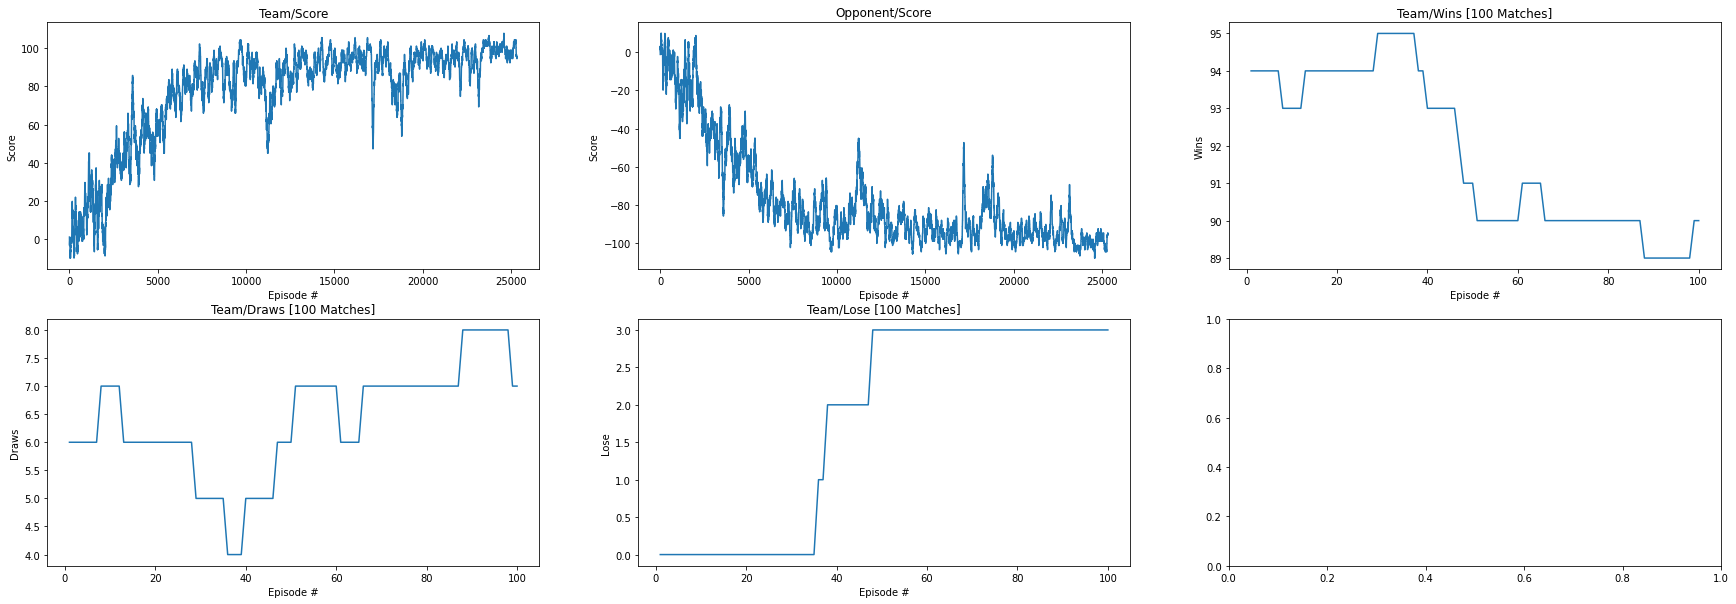

===== Goalie =====


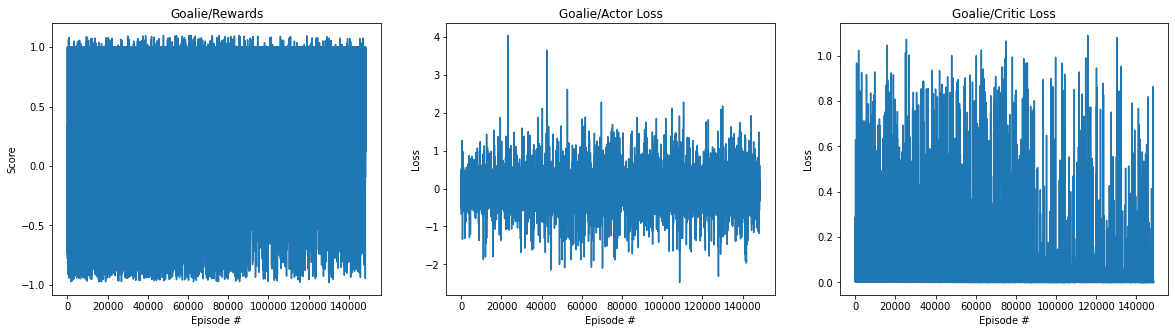

===== Striker =====


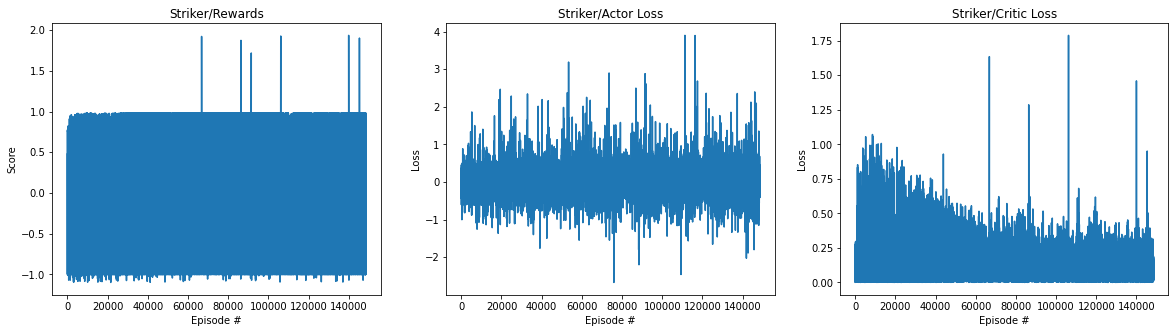

TOTAL TRAINING DURATION: 0 days, 12 hours, 46 minutes and 37 seconds
***TRAINING STOPPED AT 2022-04-02--10:44:55 


[0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 0.7650000555440784,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.835000017657876,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -0.31833333102986217,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -1

In [13]:
##################
# EXPT with much longer entropy decay rate to encourage exploration
##################

# Shared Params
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=100000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True               
params.batch_size = 32
params.beta_decay = 0.9975   # Instead of 0.995

# Goalie Params
g_params = copy.deepcopy(params)
g_params.lr = 8e-5  
g_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/goalie_run2'
g_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/goalie_run2'

# Striker Params
s_params = copy.deepcopy(params)
s_params.lr = 1e-4  
s_params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/striker_run2'
s_params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/striker_run2'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(g_params, tb, "Goalie")
s_logger = Logger(s_params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


===== Team =====


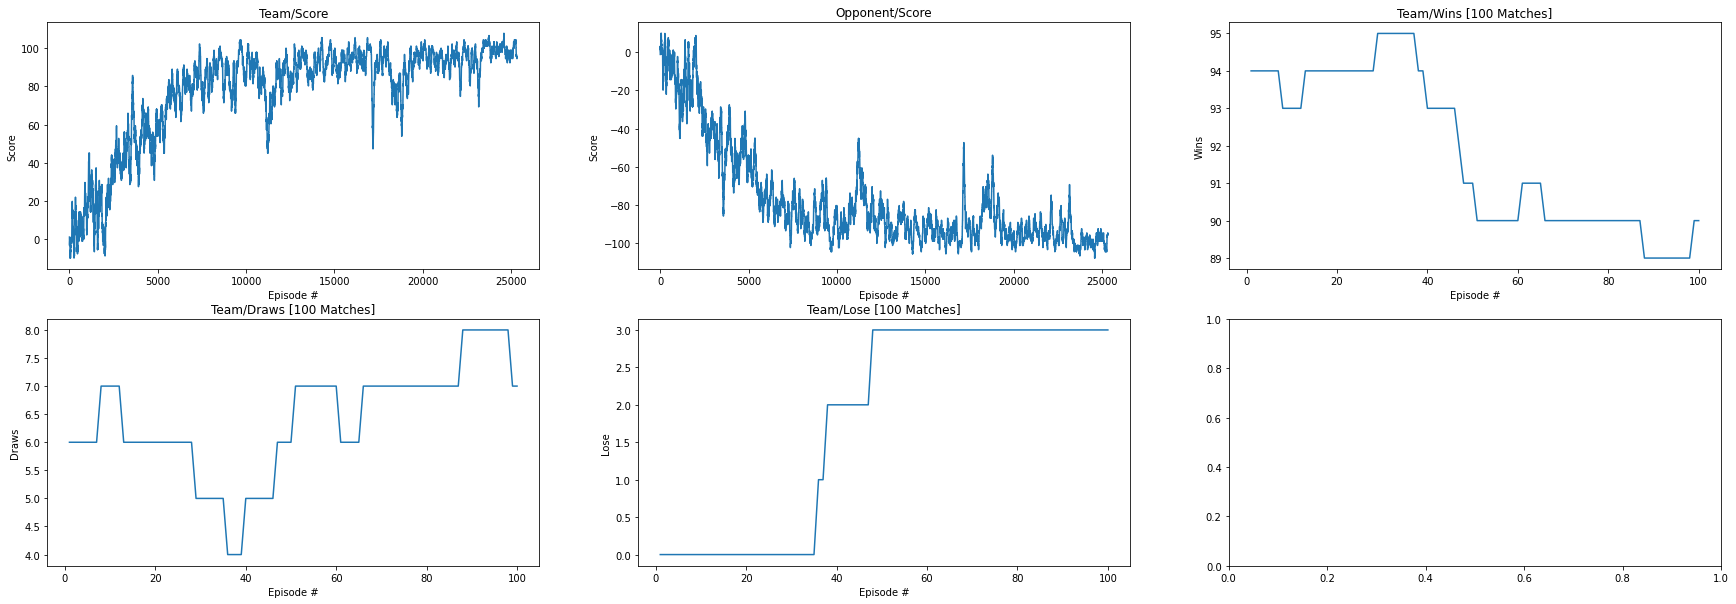

===== Goalie =====


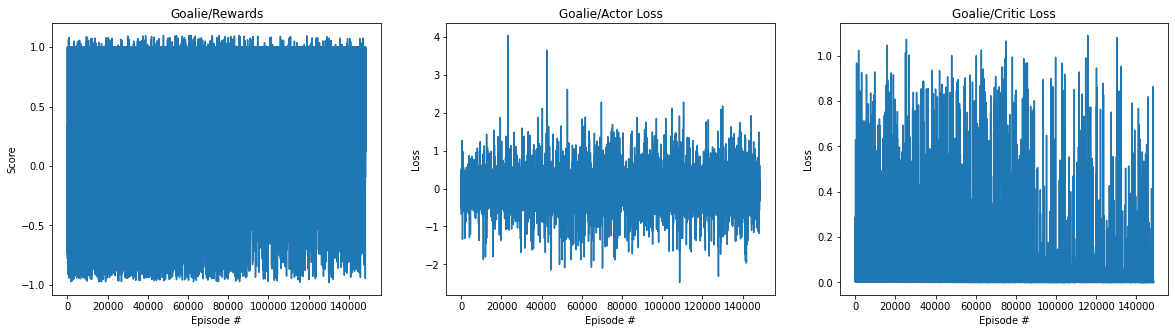

===== Striker =====


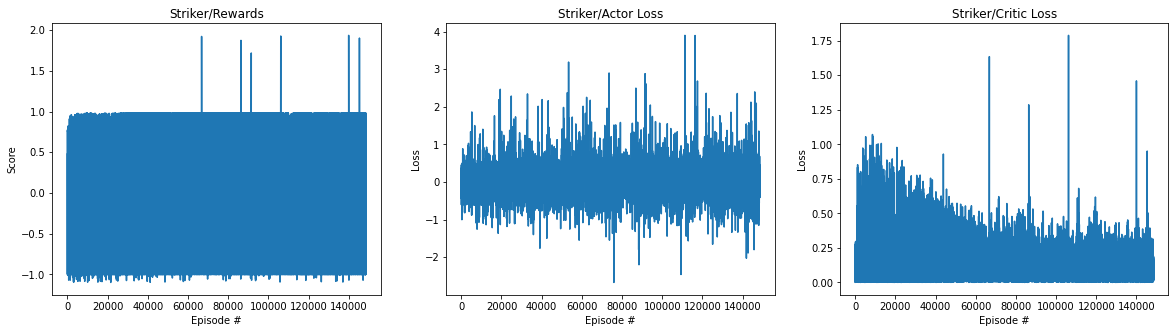

In [28]:
# Print Training Stats...
team_logger.plot_stats()
g_logger.plot_stats()                       
s_logger.plot_stats()

In [27]:
#######################
# Sample Game...
#######################

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size)
g_agent.actor_net.load_state_dict(torch.load('weights/saved/trained_against_random_agent/goalie/checkpoint_actor_ep9700.pth'))
g_agent.critic_net.load_state_dict(torch.load('weights/saved/trained_against_random_agent/goalie/checkpoint_critic_ep9700.pth'))
s_agent.actor_net.load_state_dict(torch.load('weights/saved/trained_against_random_agent/striker/checkpoint_actor_ep9700.pth'))
s_agent.critic_net.load_state_dict(torch.load('weights/saved/trained_against_random_agent/striker/checkpoint_critic_ep9700.pth'))
total_score = total_score_opp = total_wins = total_lose = total_draws = 0
num_episodes = 100
max_t = 2000
print("Playing...")

for i_episode in range(1, num_episodes+1):            # play game for 100 episodes
    env_info = env.reset(train_mode=False)                 # reset the environment    
    g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
    s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
    g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
    s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
    
    while True:
    #for t in range(max_t): 
        
        # select actions and send to environment
        g_action, g_log_prob = g_agent.act(g_states[0])
        s_action, s_log_prob = s_agent.act(s_states[0])
        g_actions = (g_action, np.random.randint(g_action_size))
        s_actions = (s_action, np.random.randint(s_action_size))
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
        env_info = env.step(actions)                            
        
        # get next states, rewards & dones
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        done = np.any(env_info[g_brain_name].local_done) 
        
        # Store in experience buffer & learn
        all_states = np.concatenate((s_states[0], s_states[1], g_states[0], g_states[1]))            
        #g_agent.step(g_states[0], all_states, g_action, g_rewards[0], g_log_prob)
        #s_agent.step(s_states[0], all_states, s_action, s_rewards[0], s_log_prob)
        g_states = g_next_states
        s_states = s_next_states
        g_scores += g_rewards
        s_scores += s_rewards   
        
        # Cache scores for display
        team_score = g_rewards[0] + s_rewards[0]
        opp_score = g_rewards[1] + s_rewards[1]
        total_score += (team_score)
        total_score_opp += (opp_score)
        
        if done: 
            break
    
    total_wins += int(1 if team_score > opp_score else 0)
    total_draws += int(1 if team_score == opp_score else 0)
    total_lose += int(1 if team_score < opp_score else 0)
        
    print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
          .format(i_episode, total_score, total_score_opp, total_wins, 
                  total_lose, total_draws, i_episode))

Playing...
Episode 1: 	Team Score: 1.10 	Opponent Score: -1.10 	 Win|Lose|Draw: 1|0|0 	 [Out of 1 Matches]
Episode 2: 	Team Score: 2.20 	Opponent Score: -2.20 	 Win|Lose|Draw: 2|0|0 	 [Out of 2 Matches]
Episode 3: 	Team Score: 3.30 	Opponent Score: -3.30 	 Win|Lose|Draw: 3|0|0 	 [Out of 3 Matches]
Episode 4: 	Team Score: 4.40 	Opponent Score: -4.40 	 Win|Lose|Draw: 4|0|0 	 [Out of 4 Matches]
Episode 5: 	Team Score: 5.50 	Opponent Score: -5.50 	 Win|Lose|Draw: 5|0|0 	 [Out of 5 Matches]
Episode 6: 	Team Score: 6.60 	Opponent Score: -6.60 	 Win|Lose|Draw: 6|0|0 	 [Out of 6 Matches]
Episode 7: 	Team Score: 7.70 	Opponent Score: -7.70 	 Win|Lose|Draw: 7|0|0 	 [Out of 7 Matches]
Episode 8: 	Team Score: 8.80 	Opponent Score: -8.80 	 Win|Lose|Draw: 8|0|0 	 [Out of 8 Matches]
Episode 9: 	Team Score: 9.90 	Opponent Score: -9.90 	 Win|Lose|Draw: 9|0|0 	 [Out of 9 Matches]
Episode 10: 	Team Score: 11.00 	Opponent Score: -11.00 	 Win|Lose|Draw: 10|0|0 	 [Out of 10 Matches]
Episode 11: 	Team Score:

Episode 83: 	Team Score: 83.60 	Opponent Score: -83.60 	 Win|Lose|Draw: 79|3|1 	 [Out of 83 Matches]
Episode 84: 	Team Score: 84.70 	Opponent Score: -84.70 	 Win|Lose|Draw: 80|3|1 	 [Out of 84 Matches]
Episode 85: 	Team Score: 85.80 	Opponent Score: -85.80 	 Win|Lose|Draw: 81|3|1 	 [Out of 85 Matches]
Episode 86: 	Team Score: 86.90 	Opponent Score: -86.90 	 Win|Lose|Draw: 82|3|1 	 [Out of 86 Matches]
Episode 87: 	Team Score: 88.00 	Opponent Score: -88.00 	 Win|Lose|Draw: 83|3|1 	 [Out of 87 Matches]
Episode 88: 	Team Score: 89.10 	Opponent Score: -89.10 	 Win|Lose|Draw: 84|3|1 	 [Out of 88 Matches]
Episode 89: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 85|3|1 	 [Out of 89 Matches]
Episode 90: 	Team Score: 90.20 	Opponent Score: -90.20 	 Win|Lose|Draw: 85|3|2 	 [Out of 90 Matches]
Episode 91: 	Team Score: 91.30 	Opponent Score: -91.30 	 Win|Lose|Draw: 86|3|2 	 [Out of 91 Matches]
Episode 92: 	Team Score: 92.40 	Opponent Score: -92.40 	 Win|Lose|Draw: 87|3|2 	 [Out of 92

# Training against a Trained Agent (Self-Play)